In [1]:
from os.path import join
from time import perf_counter as time

import matplotlib.pyplot as plt
import monai
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.networks.utils import one_hot
import numpy as np
from skimage.measure import label as skimage_label, regionprops
import torch
from tqdm import tqdm

2024-06-07 11:23:41.202938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:23:42.126284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_PATH='data/covid_small'
image = torch.from_numpy(np.load(join(DATA_PATH, 'train', 'data_0.npy'))).float()
train_label = torch.from_numpy(np.load(join(DATA_PATH, 'train', 'mask_0.npy')))
val_label = torch.from_numpy(np.load(join(DATA_PATH, 'val', 'mask_0.npy')))
image.shape

torch.Size([1024, 1024, 1024])

Text(0.5, 1.0, 'val_label')

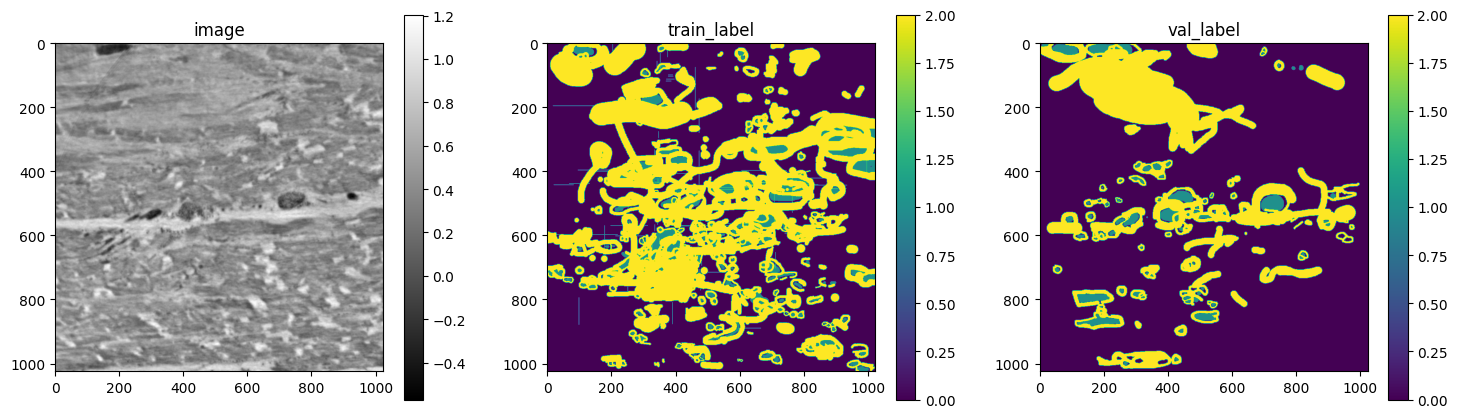

In [3]:
# subplot with 1 row and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
im = ax[0].imshow(image[:, :, image.shape[2] // 2], cmap='gray')
fig.colorbar(im, ax=ax[0])
ax[0].set_title('image')
im = ax[1].imshow(train_label.max(dim=2).values)
fig.colorbar(im, ax=ax[1])
ax[1].set_title('train_label')
im = ax[2].imshow(val_label.max(dim=2).values)
fig.colorbar(im, ax=ax[2])
ax[2].set_title('val_label')

In [4]:
PATCH_SIZE=(96,) * 3         # Size of crops
PROB_FOREGROUND_CENTER=0.95  # Probability that center of crop is a labeled foreground voxel (ensures the crops often contain a label)
from monai.transforms import (
    Compose,
    CopyItemsd,
    EnsureChannelFirstd,
    FgBgToIndicesd,
    LabelToMaskd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandAxisFlipd,
)

In [5]:
train_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label'], channel_dim='no_channel'),
    CopyItemsd(keys=['label'], times=1, names=['mask']),                                                  # Copy label to new image mask
    LabelToMaskd(keys=['mask'], select_labels=[1, 2], merge_channels=True),                               # Convert mask to binary mask showing where labels are
    FgBgToIndicesd(keys=['mask'], fg_postfix='_fg_indices', bg_postfix='_bg_indices'),                    # Precompute indices of labelled voxels
    RandCropByPosNegLabeld(keys=['image', 'label', 'mask'], label_key='label', spatial_size=PATCH_SIZE,   # Extract random crop
                            pos=PROB_FOREGROUND_CENTER, neg=(1.0 - PROB_FOREGROUND_CENTER),
                            num_samples=1, fg_indices_key='mask_fg_indices', bg_indices_key='mask_bg_indices'),
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(0, 1)),                        # Randomly rotate
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(1, 2)),                        # Randomly rotate
    RandRotate90d(keys=['image', 'label', 'mask'], prob=0.5, spatial_axes=(0, 2)),                        # Randomly rotate
    RandAxisFlipd(keys=['image', 'label', 'mask'], prob=0.1),                                             # Randomly flip
])

In [6]:
class RepeatedCacheDataset(monai.data.CacheDataset):
    """
    CacheDataset that repeats the data.
    """

    def __init__(self, *args, num_repeats: int = 1, **kwargs):
        """
        Args:
            *args: Arguments to pass to CacheDataset.
            num_repeats (int): Number of times to repeat the data.
            **kwargs: Keyword arguments to pass to CacheDataset.
        """
        super().__init__(*args, **kwargs)
        self.num_repeats = num_repeats


    def __len__(self):
        """Returns number of items in the dataset."""
        return super().__len__() * self.num_repeats


    def __getitem__(self, index):
        """Returns the item at the given index."""
        index = index % super().__len__()
        return super().__getitem__(index)

In [ ]:
TRAIN_BATCH_SIZE=2
BATCHES_PER_EPOCHS=150

train_dataset = RepeatedCacheDataset(
    data=[{ 'image': image, 'label': train_label }],
    num_repeats=BATCHES_PER_EPOCHS * TRAIN_BATCH_SIZE,
    transform=train_transforms,
    num_workers=8,
    cache_rate=1.0,
    copy_cache=False  # Important to avoid slowdowns
)

Loading dataset:   0%|                                                                                        | 0/1 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,  # No need to shuffle since we repeat the data
    num_workers=0,  # Just use the main thread for now, we just need it for visualization
)

In [ ]:
batch = next(iter(train_loader))  # Get first batch

fig, ax = plt.subplots(3, 8, figsize=(18, 6))
for i in range(8):
    ax[0, i].imshow(batch['image'][i, 0, :, :, batch['image'].shape[3] // 2], cmap='gray')
    ax[1, i].imshow(batch['label'][i, 0, :, :, batch['label'].shape[3] // 2])
    ax[2, i].imshow(batch['mask'][i, 0, :, :, batch['mask'].shape[3] // 2])

    if i == 0:
        ax[0, i].set_ylabel('image')
        ax[1, i].set_ylabel('label')
        ax[2, i].set_ylabel('mask')

In [ ]:
from typing import Tuple, List, Dict

def extract_label_patches(
    image: np.ndarray,
    label: np.ndarray,
    patch_size: Tuple[int, int, int],
) -> List[Dict[str, np.ndarray]]:
    """
    Extract patches from image where label is non-zero.

    For each connected component in label, extract the bounding box.
    Split the bounding box into overlapping patches of size patch_size.
    Extract the patches from image and label.
    Return the patches as a list of { 'image': ..., 'label': ... } dicts.

    Args:
        image (np.ndarray): Image to extract patches from.
        label (np.ndarray): Label to extract patches from.
        patch_size (tuple): Size of the patches to extract.

    Returns:
        list: List of patches as { 'image': ..., 'label': ..., 'mask': ... } dicts.
    """
    props = regionprops(skimage_label(label > 0))  # Extract connected components of labeled voxels
    patches = []
    for pp in props:
        # Extract bounding box for connected component
        cc_min = pp.bbox[:3]
        cc_max = pp.bbox[3:]

        # Extract patches covering the bounding box
        for z in range(cc_min[0] - patch_size[0] // 2, cc_max[0] + patch_size[0] // 2, patch_size[0] // 2):
            for y in range(cc_min[1] - patch_size[1] // 2, cc_max[1] + patch_size[1] // 2, patch_size[1] // 2):
                for x in range(cc_min[2] - patch_size[2] // 2, cc_max[2] + patch_size[2] // 2, patch_size[2] // 2):
                    # Ensure patch is within image bounds
                    z_begin = max(z, 0)
                    y_begin = max(y, 0)
                    x_begin = max(x, 0)
                    z_end = min(z + patch_size[0], image.shape[0])
                    y_end = min(y + patch_size[1], image.shape[1])
                    x_end = min(x + patch_size[2], image.shape[2])

                    patch_label = label[z_begin:z_end, y_begin:y_end, x_begin:x_end]
                    if not patch_label.any():
                        # Skip empty patches
                        continue
                    patch_image = image[z_begin:z_end, y_begin:y_end, x_begin:x_end]

                    if patch_image.shape != patch_size:
                        # Pad patch if it is smaller than patch_size
                        pad_size = [(0, 0)] * 3
                        for d in range(3):
                            pad_size[d] = (0, patch_size[d] - patch_image.shape[d])
                        patch_image = np.pad(patch_image, pad_size, 'constant', constant_values=0)
                        pad_size = [(0, 0)] * 3
                        for d in range(3):
                            pad_size[d] = (0, patch_size[d] - patch_label.shape[d])
                        patch_label = np.pad(patch_label, pad_size, 'constant', constant_values=0)

                    patches.append({ 'image': patch_image, 'label': patch_label, 'mask': patch_label > 0 })

    return patches

In [ ]:
VAL_BATCH_SIZE=16

val_transforms = Compose([
    EnsureChannelFirstd(keys=['image', 'label', 'mask'], channel_dim='no_channel'),
])
val_dataset = CacheDataset(
    data=extract_label_patches(image, val_label, PATCH_SIZE),
    transform=val_transforms,
    num_workers=8,
    cache_rate=1.0
)

In [ ]:
val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Just use the main thread for now, we just need it for visualization
)

In [ ]:
batch = next(iter(val_loader))  # Get first batch

fig, ax = plt.subplots(3, 8, figsize=(18, 6))
for i in range(8):
    ax[0, i].imshow(batch['image'][i, 0, :, :, batch['image'].shape[3] // 2], cmap='gray')
    ax[1, i].imshow(batch['label'][i, 0, :, :, batch['label'].shape[3] // 2])
    ax[2, i].imshow(batch['mask'][i, 0, :, :, batch['mask'].shape[3] // 2])

    if i == 0:
        ax[0, i].set_ylabel('image')
        ax[1, i].set_ylabel('label')
        ax[2, i].set_ylabel('mask')

In [ ]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout=0.2,  # Read about dropout here: https://www.deeplearningbook.org/contents/regularization.html#pf20
)

In [ ]:
checkpoint = torch.load('data/worst_model_checkpoint.pth')
model.load_state_dict(checkpoint['model'])

In [ ]:
LR = 1e-4

loss_fn = monai.losses.MaskedDiceLoss(include_background=True)
### YOUR CODE HERE ###
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
NUM_EPOCHS = 5

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=False,  # Don't shuffle since we use random crops
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    persistent_workers=True,
    pin_memory=True,
)

model.cuda()

print('Starting training')
all_train_losses = []
all_val_losses = []
best_val_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    mean_train_loss = 0
    num_samples = 0
    step = 0
    t0 = time()
    model.train()
    for batch in tqdm(train_loader):
        image_b = batch['image'].as_tensor().cuda(non_blocking=True)
        label = batch['label'].as_tensor().cuda(non_blocking=True)
        mask = batch['mask'].as_tensor().cuda(non_blocking=True)
        label = one_hot(label, num_classes=3)
        label = label[:, 1:]

        ### YOUR CODE HERE ###
        with torch.cuda.amp.autocast():
            pred = model(image_b)
            loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=None)

        mean_train_loss += loss.detach() * len(image_b)
        num_samples += len(image_b)
        step += 1

    train_time = time() - t0
    mean_train_loss = mean_train_loss / num_samples
    all_train_losses.append(mean_train_loss.item())

    mean_val_loss = 0
    num_samples = 0
    step = 0
    t0 = time()
    model.eval()
    for batch in tqdm(val_loader):
        image_b = batch['image'].as_tensor().cuda(non_blocking=True)
        label = batch['label'].as_tensor().cuda(non_blocking=True)
        mask = batch['mask'].as_tensor().cuda(non_blocking=True)

        with torch.no_grad():
            label = one_hot(label, num_classes=3)
            label = label[:, 1:]

            ### YOUR CODE HERE ###
            with torch.cuda.amp.autocast():
                pred = model(image_b)
                loss = loss_fn(input=pred.softmax(dim=1), target=label, mask=mask)

        mean_val_loss += loss * len(image_b)
        num_samples += len(image_b)
        step += 1

    val_time = time() - t0
    mean_val_loss = mean_val_loss / num_samples
    all_val_losses.append(mean_val_loss.item())
    if mean_val_loss.item() < best_val_loss:
        print('Saving best model checkpoint, epoch', epoch, 'val loss', mean_val_loss.item())
        best_val_loss = mean_val_loss
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'train_losses': all_train_losses,
            'val_losses': all_val_losses,
        }, 'model_checkpoint.pth')

    print('Epoch', epoch + 1, 'train loss', mean_train_loss.item(), 'val loss', mean_val_loss.item(), 'train time', train_time, 'seconds val time', val_time, 'seconds')

In [ ]:
checkpoint = torch.load('data/model_checkpoint.pth')
model.load_state_dict(checkpoint['model'])

In [ ]:
from monai.inferers import sliding_window_inference

INFERENCE_BATCH_SIZE = 16
WINDOW_OVERLAP = 0.5

model.eval()
with torch.no_grad():
    # Evaluate the model on the image using MONAI sliding window inference
    pred = sliding_window_inference(
        image[None, None],
        PATCH_SIZE,
        INFERENCE_BATCH_SIZE,
        lambda x: model(x.cuda()).softmax(dim=1).cpu(),  # send patch to GPU, run model, call softmax, send result back to CPU
        overlap=WINDOW_OVERLAP,
        mode='gaussian',
        progress=True,
    )
pred = pred.numpy()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image[:, :, image.shape[-1] // 2], cmap='gray')
ax[0].imshow(pred[0, 0, :, :, pred.shape[-1] // 2], alpha=0.4)
ax[1].imshow(image[:, image.shape[-2] // 2, :], cmap='gray')
ax[1].imshow(pred[0, 0, :, pred.shape[-2] // 2, :], alpha=0.4)
ax[2].imshow(image[image.shape[-3] // 2, :, :], cmap='gray')
ax[2].imshow(pred[0, 0, pred.shape[-3] // 2, :, :], alpha=0.4)
plt.show()

In [ ]:
pred = np.uint8(pred[0, 0] * 255)

from skimage.io import imsave
import nibabel as nib

# Pick one
#imsave('pred.tiff', pred)  # For paraview
nib.save(nib.Nifti1Image(pred, np.eye(4)), 'data/pred.nii.gz') # For ITK-SNAP
#np.save('pred.npy', pred)  # For TomViz